# Overview

In the notebook:
- data cleaning - entails handling of missing values (if any) and hot-encoding of categorical variables
- data exploration - entails investigating the correlation of all the variables (age, country, ...) with the user conversion
- modeling - entails training and testing a Logistic Regression model. The model is 5-fold cross-validated.
- conclusions - entails suggestions drawn from the exploration part.
The metric used to determine the best model is "Recall".

I load all the libraries I am going to use in the notebook:

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Cleaning

I upload the dataset into a pandas dataframe.
I then check the data types of the columns (I will have to hot-encode non-numerical columns)
and the percentage of missing values (NaN) in the columns.

In [38]:
data = pd.read_csv("./conversion_data.csv")

#print data types and percentage of NaN in columns
print(data.dtypes)
for col in data:
    sum_nan = data[col].isnull().sum()
    print(col, sum_nan/len(data[col])*100, ' %')

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object
country 0.0  %
age 0.0  %
new_user 0.0  %
source 0.0  %
total_pages_visited 0.0  %
converted 0.0  %


There are no Nan values, so I don't have to worry about them.
I can proceed with hot-encoding the two object-type columns ("country" and "source"):
I do not drop the hot-encoded columns yet, because I will use them in the exploration stage.

In [39]:
#First I create a list of the object-type column names.
obj_cols = []
for col in data.columns:
    if data[col].dtype == 'object':
        obj_cols.append(col)

#Then I hot-encode the columns using get_dummies, and I join the new hot-encoded columns to the old dataset.
one_hot = pd.get_dummies(data[obj_cols])
data = data.join(one_hot)

# Exploration

I start exploring the data using a correlation matrix. This step will help me draw conclusions and suggestions.

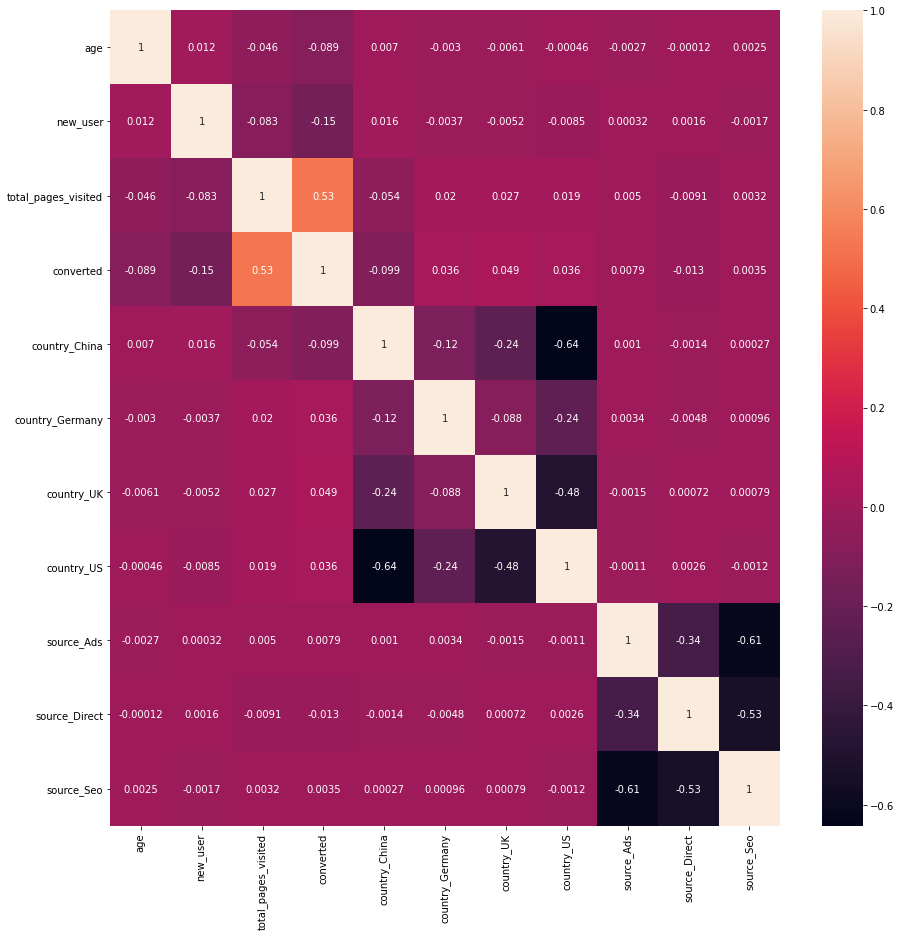

In [40]:
corrMatrix = data.corr()
plt.figure(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True)
plt.show()

There is a high correlation between the number of pages visited and the user conversion:

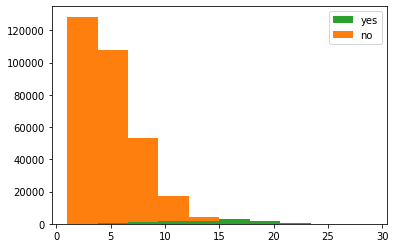

In [41]:
plt.hist(x = [data[data['converted']==1]['total_pages_visited'], data[data['converted']==0]['total_pages_visited']],
         stacked=True, color = ['tab:green','tab:orange'],label = ['yes','no'])

plt.legend()
plt.show()

The higher number of pages visited in a session the higher the chance of conversion.

I also notice a slight correlation between conversion and respectively country, age and whether the user is new or not:
exploring these relations may give some insight into how to improve the conversion rate.

Plot of conversion (yes, no) vs country:

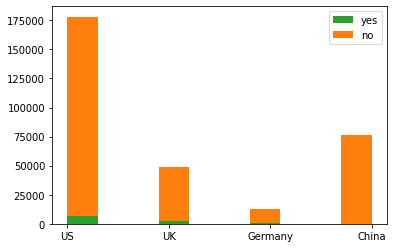

In [42]:
plt.hist(x = [data[data['converted']==1]['country'], data[data['converted']==0]['country']],
         stacked=True, color = ['tab:green','tab:orange'],label = ['yes','no'])
plt.legend()
plt.show()

Plot of conversion (yes, no) vs age:

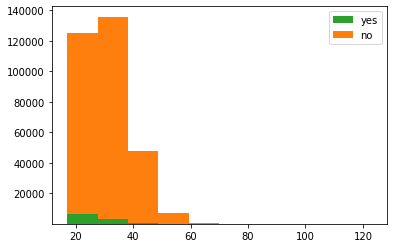

In [43]:
plt.hist(x = [data[data['converted']==1]['age'], data[data['converted']==0]['age']],
         stacked=True, color = ['tab:green','tab:orange'],label = ['yes','no'])
plt.legend()
plt.show()

Plot of conversion (yes, no) vs new_user:

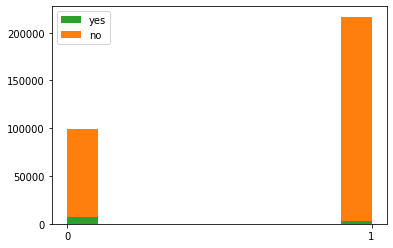

% of new users converted: 0.4588639131879083
% of non-new users converted: 2.1792953667953667


In [44]:
plt.hist(x = [data[data['converted']==1]['new_user'], data[data['converted']==0]['new_user']],
         stacked=True, color = ['tab:green','tab:orange'],label = ['yes','no'])
plt.xticks([0,1])

plt.legend()
plt.show()
converted_users = data.groupby('new_user')['converted'].count()
print("% of new users converted:", converted_users[0]/ data['new_user'].sum() )
print("% of non-new users converted:", converted_users[1]/(len(data['new_user'])- data['new_user'].sum()))


Plot of new_user (yes, no) vs source:

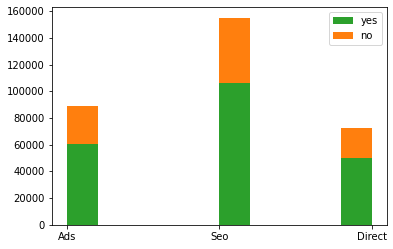

In [45]:
plt.hist(x = [data[data['new_user']==1]['source'], data[data['new_user']==0]['source']],
         stacked=True, color = ['tab:green','tab:orange'],label = ['yes','no'])
plt.legend()
plt.show()

The conversion vs age plot suggests the presence of odd ages in the dataset, so I will
eliminate the rows where the age variable is greater than 100:

In [46]:
data = data[data['age'] < 100]

# Modeling

I now can train a Logistic Regression model, using the Recall as metric to evaluate its success.
Before splitting the dataset in train and test datasets, I drop the object-type columns that have been hot-encoded and
have been used for data exploration, but will not be used for modeling purposes.

In [47]:
data = data.drop(obj_cols, axis = 1)

#Divide the dataset using the 'converted' columns as label and all the others as features.
X = data.drop(columns=['converted'])
y = data['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Train the Logistic Regression classifier
clf = LogisticRegressionCV(cv=5, class_weight='balanced', max_iter = 2000, scoring = 'recall').fit(X_train, y_train)
res = clf.predict(X_test)


print(metrics.recall_score(y_test, res))

0.9352226720647774


# Conclusions

- Number of pages visited might lead to conversion: make website easier to navigate might increase the number of pages visited
- It looks like the European markets perform better than the American and especially the Chinese market. Investigate why
the conversion rate in USA and China is so poor (probably re-assess the local marketing campaigns).
- The conversion rate is higher in people aged 40 years old or less: why don't older people buy the products?
- Returning users are more likely to convert. Also, there does not seem to be any correlation between the marketing channel
source and the conversion rate: this might imply that the general marketing campaign should undergo revision.